## Model Training

Transformers will be used to train the Machine Learning Model. It is possible due to complexity that this notebook will be trained in Google Colab and later download to this repo.



In [1]:
import pandas as pd
import numpy as np
import os
dir_root = os.getcwd()
dir_root

'/home/falconiel/CodePrograms/clasificaion_robos_fge'

In [3]:
dataset_df = pd.read_csv(os.path.join(dir_root, 'data/processed/trainset.csv'), converters={'NDD':str})
dataset_df.sample(5)

,index,NDD,RELATO,cantidad_palabras,Tipo_Delito_PJ,TARGET,LABELS_ROBO A DOMICILIO,LABELS_ROBO A PERSONAS,LABELS_ROBO A UNIDADES ECONOMICAS,"LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS",LABELS_ROBO DE CARROS,LABELS_ROBO DE MOTOS,LABELS
184303,71392,090101814023934,es el caso señor fiscal que el 16 de febrero d...,60,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
98630,37801,070101815060420,señor fiscal con fecha 11 de junio del 2015 ap...,75,ROBO,4,0,0,0,1,0,0,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH..."
315669,96009,090101815092671,es el caso sr fiscal que el 02 de septiembre d...,78,ROBO,6,0,1,0,0,0,0,ROBO A PERSONAS
295070,307595,170101815094660,el día jueves 17 de septiembre de 2015 en hora...,55,ROBO,4,0,0,0,1,0,0,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH..."
58166,207492,091001816090058,es el caso señor fiscal que el día 06 de septi...,105,ROBO,5,1,0,0,0,0,0,ROBO A DOMICILIO


In [4]:
seqlen = dataset_df.RELATO.apply(lambda x: len(x.split()))

Let us create an Histogram of the word count in Crime report

/home/falconiel/anaconda3/envs/fge_dir/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RELATO', ylabel='Density'>

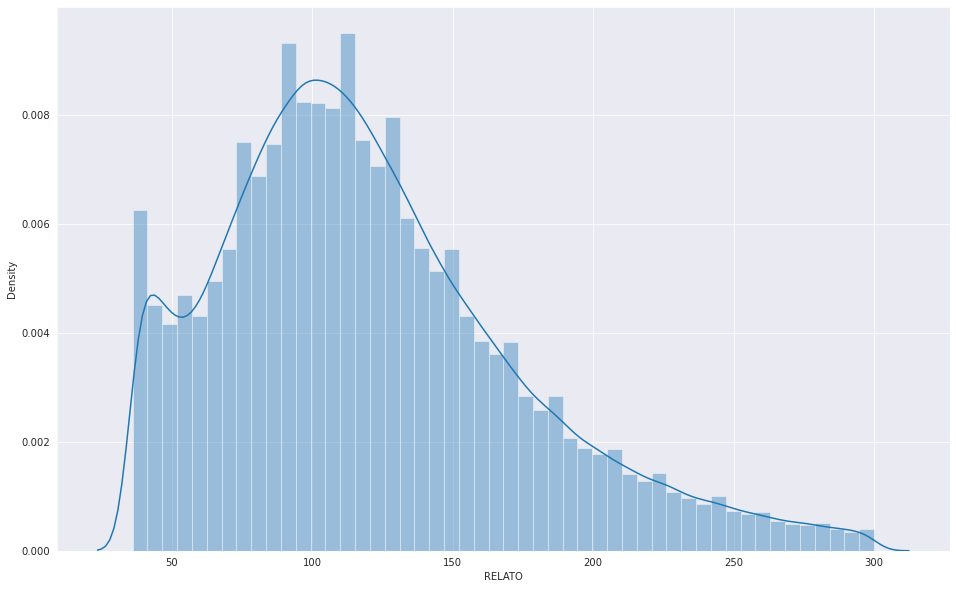

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.distplot(seqlen)

In a example solved in https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, the length of the sequence was set to the maximum span of the distplot. This would imply to use a length sequence of 300. I think padding and trucate are used in consequence with this size so that all tensors in would have the same length. I think that if we chouse $SEQ_LEN<200$, those reports with values below 200 will be truncated (This is something that I need to understand when writing the paper). Now by choosing to use the maximum length, which appears to be somehow 300, there should be no truncation but padding to some of the records. Let us consider what is the maximum length of the Crime report

In [8]:
seqlen.max()

300

In [9]:
dataset_df.cantidad_palabras.max()

300

We have already separated the original dataset in Train and Test. Because of that, we would split this train dataset in train and validation. Test set will be used at the end in order to proof the concept

In [10]:
dataset_df.columns

Index(['index', 'NDD', 'RELATO', 'cantidad_palabras', 'Tipo_Delito_PJ',
       'TARGET', 'LABELS_ROBO A DOMICILIO', 'LABELS_ROBO A PERSONAS',
       'LABELS_ROBO A UNIDADES ECONOMICAS',
       'LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
       'LABELS_ROBO DE CARROS', 'LABELS_ROBO DE MOTOS', 'LABELS'],
      dtype='object')

In [11]:
X_set = dataset_df[['RELATO']]
Y_set = dataset_df[['LABELS_ROBO A DOMICILIO', 
'LABELS_ROBO A PERSONAS',
'LABELS_ROBO A UNIDADES ECONOMICAS',
'LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
'LABELS_ROBO DE CARROS',
'LABELS_ROBO DE MOTOS']]

In [12]:
X_set.iloc[0,:], Y_set.iloc[0,:]

(RELATO    es el caso señor fiscal que el día 22 de octub...
 Name: 0, dtype: object,
 LABELS_ROBO A DOMICILIO                                        0
 LABELS_ROBO A PERSONAS                                         0
 LABELS_ROBO A UNIDADES ECONOMICAS                              0
 LABELS_ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS    0
 LABELS_ROBO DE CARROS                                          1
 LABELS_ROBO DE MOTOS                                           0
 Name: 0, dtype: int64)

In [13]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(X_set, Y_set, test_size=.2)

In [14]:
train_texts.shape, val_texts.shape, train_labels.shape, val_labels.shape

((273335, 1), (68334, 1), (273335, 6), (68334, 6))

Since the classification is of type Multicategorical, it is clear that:

$\mathbf{y} \in\mathcal{R}^6   $ corresponds to the labels of our set. The structure of $ \mathbf{X} $ will depend on the tokenization process. 

Moreover there are possible two ways to test.

1. The provided guide at https://huggingface.co/transformers/v3.2.0/custom_datasets.html, does not use attention masks. We could test first this approach.
2. We could follow the lead of https://www.youtube.com/watch?v=GYDFBfx8Ts8&t=498s, and provide both input_ids and masks_ids
3. We should compare how things go provided the classical approach by using count of words (wordvec, bag of words and others) And compare results.
4. There is something that is not being considered in this approach and it is unbalanced data. We should think about a way of balancing data

<AxesSubplot:>

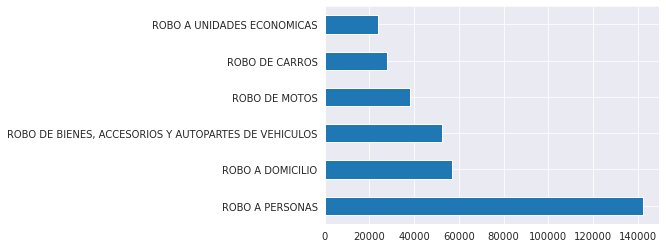

In [16]:
dataset_df.LABELS.value_counts().plot.barh()

I think and interesting way of solving could by making an ensemble by distributing different samples in each **weak** learner. Eventhough it is not a weak learner because they are actually transformer-convnet based learners. 

Also, it must be noticed that we are going through fine tuning a pre-trained bert model. What would happen if we train it from scratch? would it be better?

In [26]:
from transformers import DistilBertTokenizer, AutoTokenizer, DistilBertTokenizerFast
model_name = 'xlm-roberta-large'
model_name = 'bert-base-cased'
model_name = 'bert-base-multilingual-uncased-sentiment'
model_name = ''
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

ImportError: cannot import name 'DistilBertTokenizerFast' from 'transformers' (/home/falconiel/anaconda3/envs/fge_dir/lib/python3.9/site-packages/transformers/__init__.py)